# Correlation analysis for IFN-B response

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import collections
import gseapy
from matplotlib.colors import ListedColormap

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
# warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/schypo-0.0.0-py3.7.egg')
import schypo

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [9]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig5/'
data_path = '/data/parameter_estimation/'

### Load the data

In [10]:
tf = 'STAT1'

### Load the data

In [11]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [12]:
def simplify_name(name):
    return name.split('.')[0]

In [13]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')


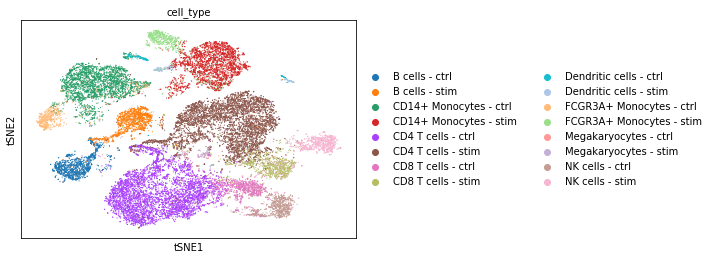

In [14]:
sc.pl.tsne(adata, color='cell_type')

In [15]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [16]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [17]:
# with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
# 	tfs = pkl.load(f)

In [18]:
# tf_df = pd.read_csv('attribute_list_entries.txt', sep='\t')
# tfs = tf_df['GeneSym'].tolist()

In [19]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

In [20]:
distances = pd.read_csv(data_path + 'chipseq/union/intersect_distances.csv').rename(columns={'gene_name':'gene'})
isgf3_genes = distances.query('distance == 0').gene.tolist()

### Function for getting mean correlations

In [21]:
def compute_mean_correlation(tf, thresh=0.0, perc=0.7, ct='CD14+ Monocytes', return_genes=False):
    
    adata_ct =  adata[adata.obs.cell == ct].copy()

    schypo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True, q=0.07)

    schypo.compute_1d_moments(
        adata_ct, inplace=True, filter_genes=True, 
        residual_var=True,filter_mean_thresh=thresh, 
        min_perc_group=perc)

    target_genes = adata_ct.var.index.tolist()
    filtered_tfs = list(set(target_genes) & set(tfs))
        
    if return_genes:
        return target_genes
    schypo.compute_2d_moments(
        adata_ct, list(itertools.product([tf], target_genes)))

    
    ctrl_mean_corr = 0
    stim_mean_corr = 0

    ctrl_count = 0
    stim_count = 0

    for group in adata_ct.uns['schypo']['groups']:

        temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
        temp[(temp > 1) | (temp < -1)] = np.nan
        temp[np.isnan(temp)] = 0

        num_cells = adata_ct.uns['schypo']['group_cells'][group].shape[0]

        if 'ctrl' in group:
            ctrl_mean_corr += temp * num_cells
            ctrl_count += ~np.isnan(temp) * num_cells

        if 'stim' in group:
            stim_mean_corr += temp * num_cells
            stim_count += ~np.isnan(temp) * num_cells

    ctrl_mean_corr /= ctrl_count
    stim_mean_corr /= stim_count

    del ctrl_count, stim_count
    
    return ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs
    # df['corr']  = df['corr'].abs()

### STAT1/STAT2 correlations

In [22]:
tf = 'STAT1'
high_genes = compute_mean_correlation(tf, thresh=0.05, perc=0.7, ct='CD14+ Monocytes', return_genes=True)

Normalizing with 741 genes
Using mask...


In [94]:
def plot_isgf3_bar(ct):
    
    tf = 'STAT1'

    ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(tf, thresh=0.06, perc=0.8, ct=ct)
    
    ctrl_df = pd.DataFrame()
    ctrl_df['gene'] = target_genes
    ctrl_df['corr'] = ctrl_mean_corr.ravel()
    ctrl_df['stim'] = 'ctrl'
    ctrl_df['isgf3'] = ctrl_df['gene'].apply(lambda x: 'ISGF3' if x in isgf3_genes else 'rest')
    ctrl_df['high_exp'] = ctrl_df['gene'].apply(lambda x: x in high_genes)
    ctrl_df = ctrl_df.query('high_exp')

    stim_df = pd.DataFrame()
    stim_df['gene'] = target_genes
    stim_df['corr'] = stim_mean_corr.ravel()
    stim_df['stim'] = 'stim'
    stim_df['isgf3'] = stim_df['gene'].apply(lambda x: 'ISGF3' if x in isgf3_genes else 'rest')
    stim_df['high_exp'] = stim_df['gene'].apply(lambda x: x in high_genes)
    stim_df = stim_df.query('high_exp')

    df = pd.concat([ctrl_df, stim_df])
    
    
    print('ctrl',stats.mannwhitneyu(ctrl_df.query('isgf3 == "ISGF3"')['corr'], ctrl_df.query('isgf3 != "ISGF3"')['corr']))
    print('stim',stats.mannwhitneyu(stim_df.query('isgf3 == "ISGF3"')['corr'], stim_df.query('isgf3 != "ISGF3"')['corr']))
    sns.boxplot(x='stim', y='corr', hue='isgf3', data=df, fliersize=1)
    plt.ylim(-0.25, 0.5)
#     plt.legend('', frameon=False)
    
    return df

Normalizing with 741 genes
Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


ctrl MannwhitneyuResult(statistic=110593.0, pvalue=1.1018960094696255e-05)
stim MannwhitneyuResult(statistic=123457.0, pvalue=0.012791460612125667)


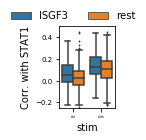

In [95]:
plt.figure(figsize=(1, 1.5))
df = plot_isgf3_bar('CD14+ Monocytes')
plt.ylabel('Corr. with STAT1')
plt.legend(frameon=False, bbox_to_anchor=(0.25, 1.3), loc='upper center', ncol=2)
plt.savefig(fig_path + 'stat1_isgf3_corrs.pdf', bbox_inches='tight')


### Ctrl vs stim distributions

In [30]:
def nan_distplot(x, **kwargs):
    
    sns.distplot(x[~np.isnan(x)], hist=False, **kwargs)

Normalizing with 741 genes
Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


STAT1 MannwhitneyuResult(statistic=744025.0, pvalue=2.7373420264599504e-92)
Normalizing with 741 genes
Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


IRF2 MannwhitneyuResult(statistic=885571.0, pvalue=1.529947143420661e-50)
Normalizing with 741 genes
Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


IRF7 MannwhitneyuResult(statistic=706993.0, pvalue=2.5253348240264553e-105)
Normalizing with 741 genes
Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


IRF9 MannwhitneyuResult(statistic=1135058.0, pvalue=5.135651647179887e-08)


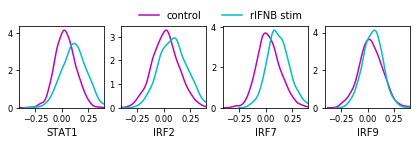

In [37]:
plt.figure(figsize=(7, 1.5));
plt.subplot(1, 4, 1);

tf = 'STAT1'
ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
    tf, thresh=0.07, perc=0.8)
print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
nan_distplot(ctrl_mean_corr.ravel(), color='m')
nan_distplot(stim_mean_corr.ravel(), color='c')
plt.xlim(-0.4, 0.4)
# plt.title(tf)
plt.xlabel('{}'.format(tf))

plt.subplot(1, 4, 2);
tf = 'IRF2'
ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
    tf, thresh=0.07, perc=0.8)
print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
nan_distplot(ctrl_mean_corr.ravel(), color='m')
nan_distplot(stim_mean_corr.ravel(), color='c')
# plt.legend(frameon=False, ncol=2, loc='upper left', bbox_to_anchor=(-0.8, 1.2))
plt.xlim(-0.4, 0.4)
# plt.title(tf)
plt.xlabel('{}'.format(tf))

plt.subplot(1, 4, 3);
tf = 'IRF7'
ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
    tf, thresh=0.07, perc=0.8)
print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
nan_distplot(ctrl_mean_corr.ravel(), label='control', color='m')
nan_distplot(stim_mean_corr.ravel(), label='rIFNB stim', color='c')
plt.legend(frameon=False, ncol=2, loc='upper left', bbox_to_anchor=(-1.1, 1.3))
plt.xlim(-0.4, 0.4)
# plt.title(tf)
plt.xlabel('{}'.format(tf))

plt.subplot(1, 4, 4);
tf = 'IRF9'
ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
    tf, thresh=0.07, perc=0.8)
print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
nan_distplot(ctrl_mean_corr.ravel(),  color='m')
nan_distplot(stim_mean_corr.ravel(),  color='c')
# plt.legend(frameon=False, ncol=2, loc='upper left', bbox_to_anchor=(-0.8, 1.2))
plt.xlim(-0.4, 0.4)
# plt.title(tf)
plt.xlabel('{}'.format(tf))

plt.savefig(fig_path + 'corr_shift.pdf'.format('HIF1A', 'IRF7'), bbox_inches='tight')


### Activation marker correlations

In [39]:
ct = 'CD14+ Monocytes'

In [40]:
distances = pd.read_csv(data_path + 'chipseq/union/intersect_distances.csv').rename(columns={'gene_name':'gene'})
isgf3_genes = distances.query('distance == 0').gene.tolist()


In [41]:
adata_ct =  adata[adata.obs.cell == ct].copy()

schypo.create_groups(adata_ct, label_columns=['ind','stim'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.07, 
    min_perc_group=0.8)

# activation_genes = ['IFIT1', 'IFIT2', 'IFI205', 'IFI47', 'RTP4', 'IRG1', 'CMPK2', 'RSAD2', 'CXCL10', 'MARCO', 'GM4902', 'AY096003', 'SDC4', 'CD40', 'CCL5', 'IL12B', 'TNFSF15', 'SAA3', 'CXCL3']
activation_genes = list(set(isgf3_genes) & set(adata_ct.var.index))
activation_genes = np.array([i for i in activation_genes])

schypo.compute_2d_moments(adata_ct, list(itertools.product(activation_genes, activation_genes)))

# schypo.compute_2d_moments(adata_ct, [('ISG15', 'ISG15')])


ctrl_mean_corr = 0
stim_mean_corr = 0

ctrl_count = 0
stim_count = 0

for group in adata_ct.uns['schypo']['groups']:

    temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
    temp[(temp > 1) | (temp < -1)] = np.nan
    temp[np.isnan(temp)] = 0

    num_cells = adata_ct.uns['schypo']['group_cells'][group].shape[0]

    if 'ctrl' in group:
        ctrl_mean_corr += temp * num_cells
        ctrl_count += ~np.isnan(temp) * num_cells

    if 'stim' in group:
        stim_mean_corr += temp * num_cells
        stim_count += ~np.isnan(temp) * num_cells

ctrl_mean_corr /= ctrl_count
stim_mean_corr /= stim_count

del ctrl_count, stim_count

Normalizing with 741 genes
Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


In [42]:
ctrl_mat = pd.DataFrame(
    data=ctrl_mean_corr.reshape(len(activation_genes), len(activation_genes)),
    index=activation_genes,
    columns=activation_genes)#.clip(-0.5, 0.5)
stim_mat = pd.DataFrame(
    data=stim_mean_corr.reshape(len(activation_genes), len(activation_genes)),
    index=activation_genes,
    columns=activation_genes)#.clip(-0.5, 0.5)

In [43]:
order = ['RPL38', 'RPS16', 'RPL27', 'RPS27A', 'RPS13',
       'RPL23A', 'RPS3A', 'RPS18', 'RPS2', 'RPL10', 'RPS7', 'RPL5',
       'RPL10A', 'RPS24', 'RPS20']
order += [
    'C11orf73', 'LAMTOR5',
       'CFLAR', 'CCRL2', 'WTAP', 'CD68', 'FTL', 'GCLM', 'LYN', 'RBCK1',
       'OASL', 'IFITM3', 'ISG15', 'ISG20', 'PSMB9', 'WARS', 'NMI', 'IRF7',
       'EPSTI1', 'PSMB8', 'GNG5', 'VIM', 'MYL12A', 'CFL1', 'IFI35',
       'TAP1', 'B2M', 'PLSCR1'
]

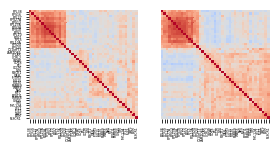

In [61]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'3.1',
         'ytick.labelsize':'3.1'}
pylab.rcParams.update(params)


plt.figure(figsize=(5, 2))
plt.subplots_adjust(wspace=-0.1)
plt.subplot(1, 2, 1)
sns.heatmap(ctrl_mat.loc[order, order], center=0, cmap='coolwarm', vmin=-0.5, vmax=1, square=True, yticklabels=1, xticklabels=1, cbar=False)
plt.subplot(1, 2, 2)
sns.heatmap(stim_mat.loc[order, order], center=0, cmap='coolwarm', vmin=-0.5, vmax=1, square=True, yticklabels=False, xticklabels=1, cbar=False)

plt.savefig(fig_path + 'emerging_corr_heatmap.pdf', bbox_inches='tight')


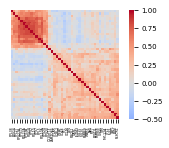

In [62]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'3.1',
         'ytick.labelsize':'x-small'}
pylab.rcParams.update(params)


plt.figure(figsize=(5, 2))
plt.subplots_adjust(wspace=-0.5)
plt.subplot(1, 2, 1)
sns.heatmap(ctrl_mat.loc[order, order], center=0, cmap='coolwarm', vmin=-0.5, vmax=1, square=True, yticklabels=1, xticklabels=1, cbar=True)
plt.subplot(1, 2, 2)
sns.heatmap(stim_mat.loc[order, order], center=0, cmap='coolwarm', vmin=-0.5, vmax=1, square=True, yticklabels=False, xticklabels=1, cbar=True)

plt.savefig(fig_path + 'emerging_corr_heatmap_colorbar.pdf', bbox_inches='tight')

### See what TFs are available

### DC hits

In [214]:
adata_ct = sc.read(data_path + 'result_2d/mono_ifn/tf_JUNB.h5ad')

In [215]:
adata_ct.uns['schypo'].keys()

dict_keys(['1d_moments', '2d_ht', '2d_moments', 'all_approx_size_factor', 'all_size_factor', 'all_total_size_factor', 'approx_size_factor', 'estimator_type', 'gene_filter', 'gene_list', 'group_cells', 'groups', 'label_columns', 'label_delimiter', 'least_variable_genes', 'mv_regressor', 'overall_gene_filter', 'q', 'size_factor'])

In [216]:
df = schypo.get_2d_ht_result(adata_ct)

In [217]:
ctrl_mean_corr = 0
stim_mean_corr = 0

ctrl_count = 0
stim_count = 0

for group in adata_ct.uns['schypo']['groups']:
    
    temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
    temp[(temp > 1) | (temp < -1)] = np.nan
    temp[np.isnan(temp)] = 0
        
    if 'ctrl' in group:
        ctrl_mean_corr += temp
        ctrl_count += ~np.isnan(temp)
        
    if 'stim' in group:
        stim_mean_corr += temp
        stim_count += ~np.isnan(temp)

ctrl_mean_corr /= ctrl_count
stim_mean_corr /= stim_count

del ctrl_count, stim_count

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


In [218]:
df['ctrl'] = ctrl_mean_corr
df['stim'] = stim_mean_corr

df['ctrl_mag'] = np.absolute(ctrl_mean_corr)
df['stim_mag'] = np.absolute(stim_mean_corr)

In [219]:
high_corr_df = df.query('ctrl_mag > 0.25 | stim_mag > 0.25').copy()
high_corr_df['corr_fdr'] = schypo.util._fdrcorrect(high_corr_df['corr_pval'])

In [220]:
high_corr_df.shape

(76, 9)

In [126]:
high_corr_df['gene_2'].drop_duplicates().shape

(425,)

In [127]:
high_corr_df['gene_1'].drop_duplicates().shape

(2,)

In [128]:
high_corr_df.query('corr_fdr < 0.1').shape

(143, 9)

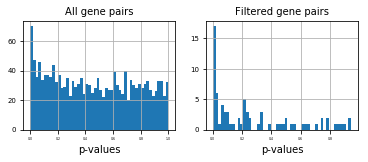

In [221]:
plt.figure(figsize=(6, 2));
plt.subplot(1, 2, 1);
df['corr_pval'].hist(bins=50)
plt.title('All gene pairs')
plt.xlabel('p-values')
plt.subplot(1, 2, 2);
high_corr_df['corr_pval'].hist(bins=50)
plt.title('Filtered gene pairs')
plt.xlabel('p-values')

plt.savefig(fig_path + 'dc_calibration.pdf', bbox_inches='tight')


In [224]:
a = ['TAGLN2',
 'GUK1',
 'NFE2L2',
 'CFLAR',
 'CCNL1',
 'SERPINB9',
 'ATP5J2',
 'NAMPT',
 'DERL1',
 'FAM49B',
 'GDI2',
 'IRF7',
 'GPR84',
 'ARL6IP4',
 'SRP14',
 'LITAF',
 'GADD45B',
 'PPP1R15A',
 'ST13',
 'PIM3']
b = """HNRNPR
LAPTM5
TMEM59
GCLM
PDE4DIP
SSR2
CDC73
GPR137B
CHMP3
LINC00152
ARID5A
PLEKHB2
CFLAR
EIF4E2
ANXA5
CAST
TNFAIP8
SNX2
PAIP2
CD74
GNB2L1
HLA-F
HSPA1A
HLA-DRA
AMD1
SNX8
HNRNPA2B1
RHEB
ATP6V1H
RAB2A
DERL1
FAM49B
NINJ1
UBE2D1
GHITM
GLRX3
HTATIP2
CASP1
HSPA8
TNFRSF1A
EMP1
TMBIM6
NACA
UBE2N
TPT1
C14orf166
WARS
B2M
ANXA2
LACTB
PKM
KARS
EIF1
RPL27
MYL12B
SNRPB2
EIF6
CTNNBL1
STK4
STAU1
OAZ1
JUNB
IL4I1
RPS9
RPL28
RTCB
ATP5J""".split()

In [225]:
set(a) & set(b)

{'CFLAR', 'DERL1', 'FAM49B'}

In [223]:
high_corr_df.query('corr_fdr < 0.1')['gene_2'].tolist()

['TAGLN2',
 'GUK1',
 'NFE2L2',
 'CFLAR',
 'CCNL1',
 'SERPINB9',
 'ATP5J2',
 'NAMPT',
 'DERL1',
 'FAM49B',
 'GDI2',
 'IRF7',
 'GPR84',
 'ARL6IP4',
 'SRP14',
 'LITAF',
 'GADD45B',
 'PPP1R15A',
 'ST13',
 'PIM3']

In [138]:
high_corr_df.query('corr_fdr < 0.1 & gene_1 == "STAT1"')

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,ctrl,stim,ctrl_mag,stim_mag
1606,STAT1,PARK7,0.287856,0.0206,0.084410,0.016718,0.262859,0.016718,0.262859
1626,STAT1,SH3BGRL3,0.210628,0.0081,0.051676,0.044038,0.265635,0.044038,0.265635
1708,STAT1,PSMD4,0.395586,0.0233,0.090332,0.028288,0.324796,0.028288,0.324796
1710,STAT1,S100A10,0.253496,0.0029,0.027067,-0.010125,0.286855,0.010125,0.286855
1711,STAT1,S100A11,0.275011,0.0009,0.015641,0.033434,0.277966,0.033434,0.277966
1718,STAT1,SNAPIN,0.468517,0.0049,0.036318,-0.254321,0.194512,0.254321,0.194512
1839,STAT1,ACTR3,0.383957,0.0012,0.016800,-0.013215,0.297729,0.013215,0.297729
1863,STAT1,NFE2L2,0.410062,0.0012,0.016800,-0.058520,0.287333,0.058520,0.287333
1895,STAT1,EMC3,0.410905,0.0035,0.029400,-0.094563,0.337513,0.094563,0.337513
1949,STAT1,TPRA1,0.340217,0.0103,0.057680,-0.000711,0.373802,0.000711,0.373802


In [136]:
for i in high_corr_df.query('corr_fdr < 0.1 & gene_1 == "STAT1" & corr_coef > 0').gene_2.tolist():
    print(i)

PARK7
SH3BGRL3
PSMD4
S100A10
S100A11
SNAPIN
ACTR3
NFE2L2
EMC3
TPRA1
PLSCR1
MFSD1
WDR1
UBE2D3
ANXA5
IRF2
IL7R
TAF7
CD74
CLIC1
HLA-DRA
HLA-DRB1
HLA-DQA1
HLA-DPA1
SNX3
ACTB
SAMD9L
ARPC1B
ZYX
MSN
TM2D2
SDCBP
ANXA1
VIM
PSAP
NDUFB8-1
PTPRE
TALDO1
EIF4G2
PSMA1
CFL1
CHORDC1
GAPDH
TPI1
HNRNPA1
LYZ
NDUFA12
KTN1
PDIA3
SQRDL
ANXA2
LACTB
PKM
ALDOA
TRADD
COTL1
COX4I1
EIF4A1
PSMD11
MYL12A
ANKRD12
ABHD3
CNDP2
SIRPA
TOP1
GPR108
TYROBP
AP2S1
NAPA
MBOAT7
XBP1
TSPO


In [203]:
df.query('gene_2 == "TRIM22"')

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,ctrl,stim,ctrl_mag,stim_mag


In [196]:
high_corr_df.query('corr_fdr < 0.1 & gene_1 == "IRF7" & corr_coef > 0')

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,ctrl,stim,ctrl_mag,stim_mag
22,IRF7,HNRNPR,0.501484,0.0004,0.011859,-0.317765,0.270291,0.317765,0.270291
40,IRF7,LAPTM5,0.312169,0.0005,0.012600,0.019040,0.311502,0.019040,0.311502
71,IRF7,TMEM59,0.442638,0.0007,0.013067,0.014194,0.328084,0.014194,0.328084
87,IRF7,GCLM,0.328152,0.0095,0.056700,-0.021402,0.302188,0.021402,0.302188
101,IRF7,PDE4DIP,0.277931,0.0125,0.063636,-0.079559,0.316970,0.079559,0.316970
132,IRF7,SSR2,0.295387,0.0184,0.078353,-0.028694,0.298941,0.028694,0.298941
160,IRF7,CDC73,0.410307,0.0222,0.088101,-0.182872,0.318869,0.182872,0.318869
177,IRF7,GPR137B,0.433431,0.0001,0.004582,-0.144837,0.253684,0.144837,0.253684
231,IRF7,CHMP3,0.349403,0.0256,0.094178,-0.371071,0.129869,0.371071,0.129869
232,IRF7,LINC00152,0.343793,0.0054,0.038880,-0.156269,0.262406,0.156269,0.262406


In [137]:
for i in high_corr_df.query('corr_fdr < 0.1 & gene_1 == "IRF7" & corr_coef > 0').gene_2.tolist():
    print(i)

HNRNPR
LAPTM5
TMEM59
GCLM
PDE4DIP
SSR2
CDC73
GPR137B
CHMP3
LINC00152
ARID5A
PLEKHB2
CFLAR
EIF4E2
ANXA5
CAST
TNFAIP8
SNX2
PAIP2
CD74
GNB2L1
HLA-F
HSPA1A
HLA-DRA
AMD1
SNX8
HNRNPA2B1
RHEB
ATP6V1H
RAB2A
DERL1
FAM49B
NINJ1
UBE2D1
GHITM
GLRX3
HTATIP2
CASP1
HSPA8
TNFRSF1A
EMP1
TMBIM6
NACA
UBE2N
TPT1
C14orf166
WARS
B2M
ANXA2
LACTB
PKM
KARS
EIF1
RPL27
MYL12B
SNRPB2
EIF6
CTNNBL1
STK4
STAU1
OAZ1
JUNB
IL4I1
RPS9
RPL28
RTCB
ATP5J


### Get correlations for network

In [204]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(cat ifnadata_ct.obs['stim'], adata_ct.shape[0])

schypo.create_groups(adata_ct, label_columns=['ind','stim'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)

genes = adata_ct.var.index.tolist()
gene_1 = list(set(tfs) & set(genes))
gene_2 = genes
gene_pairs = list(itertools.product(gene_1, gene_2))

schypo.compute_2d_moments(adata_ct,gene_pairs)

Normalizing with 741 genes
Using mask...


In [206]:
ctrl_mean_corr = 0
stim_mean_corr = 0

ctrl_count = 0
stim_count = 0

for group in adata_ct.uns['schypo']['groups']:
    
    temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
    temp[(temp > 1) | (temp < -1)] = np.nan
    temp[np.isnan(temp)] = 0
        
    num_cells = adata_ct.uns['schypo']['group_cells'][group].shape[0]

    if 'ctrl' in group:
        ctrl_mean_corr += temp * num_cells
        ctrl_count += ~np.isnan(temp) * num_cells

    if 'stim' in group:
        stim_mean_corr += temp * num_cells
        stim_count += ~np.isnan(temp) * num_cells

ctrl_mean_corr /= ctrl_count
stim_mean_corr /= stim_count

del ctrl_count, stim_count

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


In [208]:
df = pd.DataFrame(gene_pairs, columns=['gene_1', 'gene_2'])
df['ctrl'] = ctrl_mean_corr
df['stim'] = stim_mean_corr
df['ctrl_mag'] = np.absolute(ctrl_mean_corr)
df['stim_mag'] = np.absolute(stim_mean_corr)

In [210]:
edge_df = df.query('ctrl_mag > 0.3 | stim_mag > 0.3').query('gene_1 != gene_2').copy()
edge_df['sig'] = 0#edge_df['corr_fdr'] < 0.1
edge_df['TF'] = 1

In [211]:
edge_df.shape

(2895, 8)

In [213]:
edge_df.to_csv('filtered_edges.csv', index=False)

### Examples

In [192]:
def get_ind_corr(adata, gene_1, gene_2):
    
    idx = [(g[0], g[1]) for g in adata.uns['schypo']['2d_moments']['gene_pairs']]
    idx = idx.index((gene_1, gene_2))
    
    df_list = []
    for group in adata.uns['schypo']['groups']:
        _, stim, ind = group.split('^')
        df_list.append((stim,ind,adata.uns['schypo']['2d_moments'][group]['corr'][idx]))
    return pd.DataFrame(df_list, columns=[ 'ind','stim', 'corr']).query('corr < 1 & corr > -1')


def variability_scatter(X, c, vmin=None, vmax=None, xlim=None, ylim=None, s=5):
    
    order = np.argsort(c)
    c = np.clip(c, a_min=0, a_max=np.quantile(c, 0.995))
    plt.scatter(X[order, 0], X[order, 1], c=c[order], cmap='viridis', s=s, vmin=vmin, vmax=vmax)

    plt.colorbar(orientation='horizontal');
    if xlim is not None and ylim is not None:
        plt.xlim(xlim);
        plt.ylim(ylim);
    plt.xticks([]); plt.yticks([]);
    
    
def plot_microscopy(X, c1, c2, labels, s=5, end_num=-5, alpha=0.1, xlim=None, ylim=None, remove_axis=True):
    
    N = X.shape[0]
    
    c1_mean = np.zeros(c1.shape[0])
    c2_mean = np.zeros(c2.shape[0])
    c1_mean[labels] = c1[labels].mean()
    c1_mean[~labels] = c1[~labels].mean()
    c2_mean[labels] = c2[labels].mean()
    c2_mean[~labels] = c2[~labels].mean()
    
    prod = (c1-c1_mean)*(c2-c2_mean)
#     prod = c1*c2
    
    c1 = np.clip(c1, a_min=0, a_max=np.sort(c1)[end_num])
    c2 = np.clip(c2, a_min=0, a_max=np.sort(c2)[end_num])
    prod = np.clip(prod, a_min=np.sort(prod)[50], a_max=np.sort(prod)[end_num])
    
    print(prod.min(), prod.max())

    c1 = (c1 - c1.min())/(c1.max()-c1.min())
    c2 = (c2 - c2.min())/(c2.max()-c2.min())
    prod = (prod - prod.min())/(prod.max()-prod.min())
    order_1 = np.argsort(c1)
    order_2 = np.argsort(c2)
    order_prod = np.argsort(prod)
    
    print(prod)
    ListedColormap(sns.dark_palette("red", 100).as_hex())
        
    plt.subplot(1, 3, 1); 
        
    plt.scatter(X[order_1, 0], X[order_1, 1], c=c1[order_1], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("red", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    plt.title(gene_1)
        
    plt.subplot(1, 3, 2); 
    plt.scatter(X[order_2, 0], X[order_2, 1], c=c2[order_2], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("green", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    plt.title(gene_2)

        
    plt.subplot(1, 3, 3); 
    plt.scatter(X[order_prod, 0], X[order_prod, 1], c=prod[order_prod], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("orange", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    plt.title(gene_1 + ' * ' + gene_2)
    
    return prod
        

norm_adata = adata.copy()
norm_adata = norm_adata[norm_adata.obs.cell == 'CD14+ Monocytes'].copy()
norm_adata = norm_adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
dat = norm_adata
labels = (norm_adata.obs.stim == 'stim').values

In [193]:
labels.shape

(5341,)

-17.117710336250084 80.59771052271617
[0.2288857  0.18585971 0.18585971 ... 0.21830527 0.19914123 0.19914123]


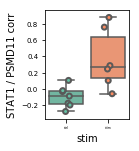

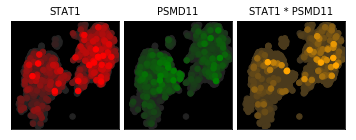

In [201]:
gene_1, gene_2 = 'STAT1', 'PSMD11'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)
plt.ylabel('{} / {} corr'.format(gene_1, gene_2))

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

prods = plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    labels=labels,
    end_num=-5,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

# plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')
plt.savefig(fig_path + '{}_{}_scatter.png'.format(gene_1, gene_2), bbox_inches='tight')

-28.31605326850905 133.09259204097344
[0.18110052 0.18110052 0.18110052 ... 0.17083618 0.19156107 0.21538702]


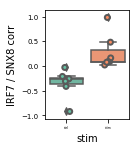

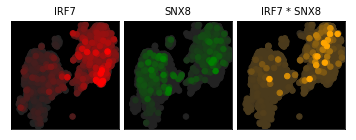

In [202]:
gene_1, gene_2 = 'IRF7', 'SNX8'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)
plt.ylabel('{} / {} corr'.format(gene_1, gene_2))

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    labels=labels,
    end_num=-5,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')
plt.savefig(fig_path + '{}_{}_scatter.png'.format(gene_1, gene_2), bbox_inches='tight')

-164.9709781904519 1255.1077571216601
[0.10889595 0.12344655 0.12980533 ... 0.13386345 0.05654637 0.10109223]


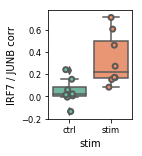

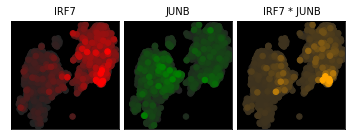

In [752]:
gene_1, gene_2 = 'IRF7', 'JUNB'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)
plt.ylabel('{} / {} corr'.format(gene_1, gene_2))

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    end_num=-5,
    labels=labels,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')
plt.savefig(fig_path + '{}_{}_scatter.png'.format(gene_1, gene_2), bbox_inches='tight')